In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from tqdm import tqdm
import pandas as pd
from scipy.stats import pearsonr

In [8]:
vd = readsav("vdama_26965.190820.1115.dat")['vd']

vd_files = glob('./26965/vdama_26965.*.dat')

In [9]:
vd.dtype.names

('OBNM',
 'BLAZE',
 'CONTIN',
 'CTS',
 'CONT_OFFSET',
 'EPOCH',
 'GDPIX',
 'JD',
 'NPIX_CHUNK',
 'ORD',
 'PERROR',
 'PIXT',
 'PIXOB',
 'RED_CHI',
 'RMS',
 'SMOD',
 'SOBS',
 'STEL',
 'STMP',
 'STMP_MORPH',
 'TEMPL_WT',
 'TEMPL_NM',
 'UNC',
 'WAV_LAB',
 'WAV',
 'WTEL',
 'WTMP',
 'VEL',
 'WEIGHT')

In [10]:
numchunk = 1386

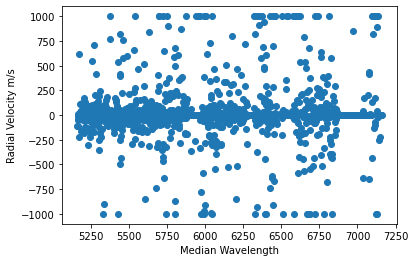

In [11]:
#median wav on x and rv on y (vel)
med_wav = np.zeros(numchunk)

for icnk,ncnk in enumerate(range(0,numchunk)):
    med_wav[icnk] = np.median(vd.wav[ncnk])
    

plt.scatter(med_wav,vd.vel)
plt.xlabel('Median Wavelength')
plt.ylabel('Radial Velocity m/s')
plt.show()

#chunks are all behaving differently, so we use this to better understand what the RV really is

In [12]:
file_name = './26965_activity.csv'
df = pd.read_csv(file_name)
df.head()

,File,Time [MJD],Epoch,SNR,CBC RV [m/s],CBC RV Err. [m/s],CCF RV [m/s],CCF RV Err. [m/s],S Value,H-alpha Emission,H-alpha Equiv. Width [A],CCF FWHM [m/s],CCF FWHM Err. [m/s],BIS [m/s],V_span [m/s],Bi-Gaussian [m/s],Skew Normal,Date Generated
0,26965_190820.1115.fits,58715.487206,5,201.054719,0.808395,0.453045,-42339.29522,0.26474,0.218595,0.214439,1.560971,6591.483264,27.640611,-71.589982,-61.367083,0.748646,-0.942206,2022-06-14T19:00:33.604
1,26965_190824.1349.fits,58719.469213,5,207.624661,-1.044521,0.379194,-42341.19811,0.25551,0.202251,0.213199,1.561505,6603.370528,27.726042,-67.929450,-58.783606,0.581876,-0.931480,2022-06-14T19:00:36.926
2,26965_190824.1350.fits,58719.471884,5,203.504300,-2.870517,0.421004,-42342.12831,0.26022,0.202251,0.215830,1.547990,6601.249197,27.761682,-69.280474,-59.803878,0.634615,-0.006403,2022-06-14T19:00:39.936
3,26965_190825.1237.fits,58720.497347,5,208.827680,-1.894605,0.420891,-42342.21946,0.26869,NaN,0.215981,1.546532,6607.213779,28.281000,-66.496215,-58.325077,0.457273,0.001268,2022-06-14T19:00:42.910
4,26965_191008.1133.fits,58764.403023,5,214.758003,0.839369,0.341155,-42339.09758,0.26467,NaN,0.212081,1.564194,6603.098832,28.844911,-70.267507,-61.663367,0.722900,-0.948795,2022-06-14T19:00:46.100


In [14]:
df.columns
time = df['Time [MJD]']
velocity = df['CBC RV [m/s]']
velocityerr = df['CCF RV Err. [m/s]']

actind = df['S Value']
ccffwhm = df['CCF FWHM [m/s]']
halphacore = df['H-alpha Emission']
halphawidth = df['H-alpha Equiv. Width [A]']
bisccf = df['BIS [m/s]']
velspan = df['V_span [m/s]']
bigauss = df['Bi-Gaussian [m/s]']
skewnorm = df['Skew Normal']

ccffwhmerr = df['CCF FWHM Err. [m/s]']

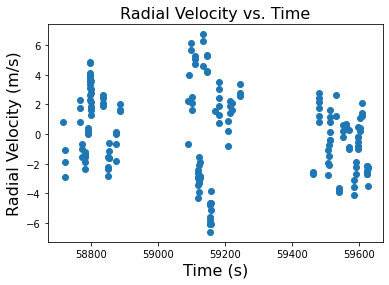

In [15]:
plt.scatter(time, velocity)
plt.title('Radial Velocity vs. Time',fontsize=16)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('Radial Velocity (m/s)',fontsize=16)
plt.show()

In [20]:
medwavall = np.zeros((numchunk,len(vd_files)))

velo = np.zeros((numchunk,len(vd_files)))

pccall = np.zeros(numchunk)

for filenum, filenam in enumerate(tqdm(vd_files)):
    vd = readsav(filenam)['vd']
    for icnk,ncnk in enumerate(range(0,numchunk)):
        medwavall[icnk,filenum] = np.median(vd.wav[ncnk])
        
        velo[icnk,filenum] = vd.vel[ncnk]

100%|█████████████████████████████████████████| 187/187 [04:02<00:00,  1.30s/it]


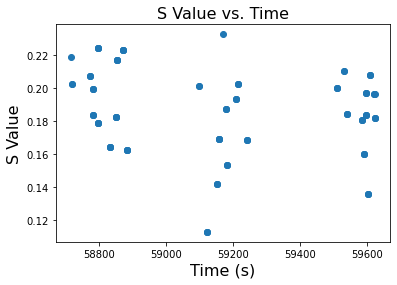

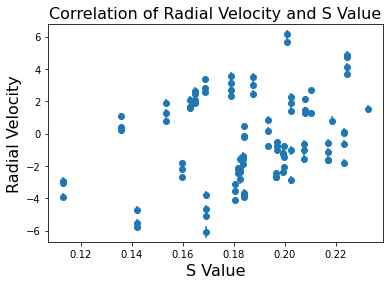

100%|██████████████████████████████████████| 1386/1386 [00:01<00:00, 828.30it/s]


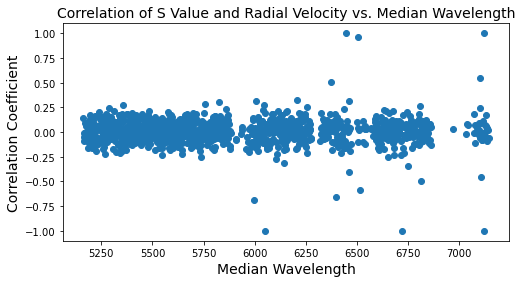

In [22]:
#Using the activity indicator S Value

plt.scatter(time, actind)
plt.title('S Value vs. Time',fontsize=16)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('S Value',fontsize=16)
plt.show()

plt.errorbar(actind, velocity, yerr=velocityerr, fmt='o')
plt.title('Correlation of Radial Velocity and S Value',fontsize=16)
plt.xlabel('S Value',fontsize=16)
plt.ylabel('Radial Velocity',fontsize=16)
plt.show()

for icnk,ncnk in enumerate(tqdm(range(0,numchunk))):
    nan_mask = np.logical_and(np.isfinite(velo[ncnk]),np.isfinite(df['S Value']))
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=0)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=1000)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=-1000)
    
    if np.sum(nan_mask) < 2:
        pccall[ncnk]=np.nan
        continue
    
    pcc, pcc_pval = pearsonr(velo[ncnk][nan_mask],df['S Value'][nan_mask])
    pccall[ncnk] = pcc

plt.figure(figsize=(8,4))
plt.scatter(medwavall[:,0],pccall)
plt.title('Correlation of S Value and Radial Velocity vs. Median Wavelength',fontsize=14)
plt.xlabel('Median Wavelength',fontsize=14)
plt.ylabel('Correlation Coefficient',fontsize=14)
plt.show()

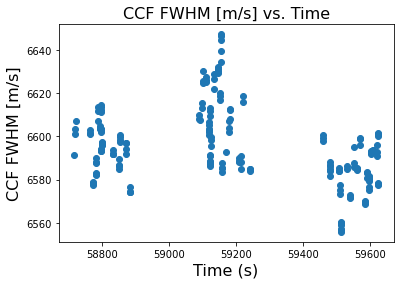

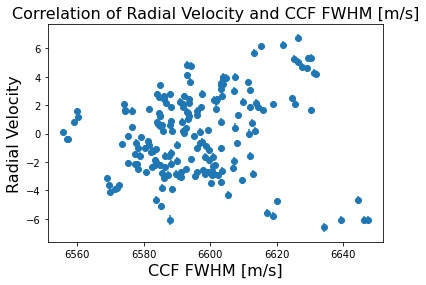

100%|█████████████████████████████████████| 1386/1386 [00:01<00:00, 1001.82it/s]


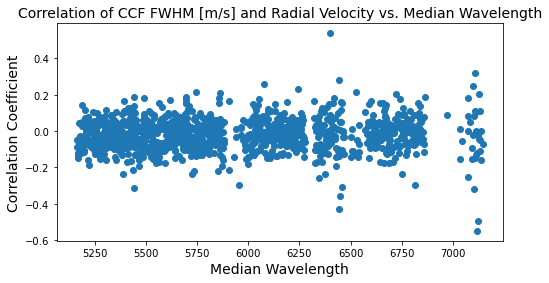

In [23]:
#Using the activity indicator CCF FWHM [m/s]
ccfferr = df['CCF FWHM Err. [m/s]']
plt.scatter(time, ccffwhm)

plt.title('CCF FWHM [m/s] vs. Time',fontsize=16)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('CCF FWHM [m/s]',fontsize=16)
plt.show()

plt.errorbar(ccffwhm, velocity, yerr=velocityerr, fmt="o")
plt.title('Correlation of Radial Velocity and CCF FWHM [m/s]',fontsize=16)
plt.xlabel('CCF FWHM [m/s]',fontsize=16)
plt.ylabel('Radial Velocity',fontsize=16)
plt.show()

for icnk,ncnk in enumerate(tqdm(range(0,numchunk))):
    nan_mask = np.logical_and(np.isfinite(velo[ncnk]),np.isfinite(df['CCF FWHM [m/s]']))
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=0)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=1000)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=-1000)
    
    if np.sum(nan_mask) < 2:
        pccall[ncnk]=np.nan
        continue
    
    pcc, pcc_pval = pearsonr(velo[ncnk][nan_mask],df['CCF FWHM [m/s]'][nan_mask])
    pccall[ncnk] = pcc

plt.figure(figsize=(8,4))
plt.scatter(medwavall[:,0],pccall)

plt.title('Correlation of CCF FWHM [m/s] and Radial Velocity vs. Median Wavelength',fontsize=14)
plt.xlabel('Median Wavelength',fontsize=14)
plt.ylabel('Correlation Coefficient',fontsize=14)
plt.show()

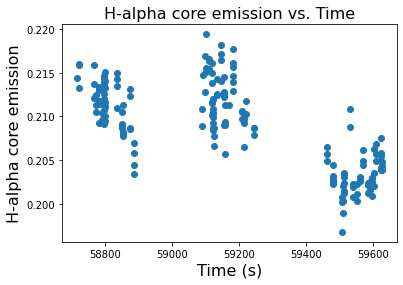

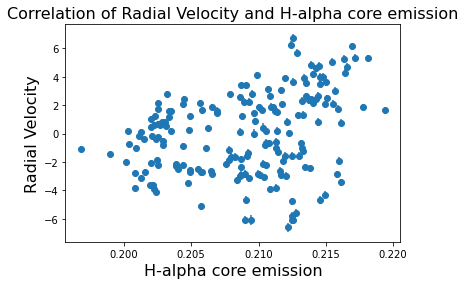

100%|██████████████████████████████████████| 1386/1386 [00:01<00:00, 837.93it/s]


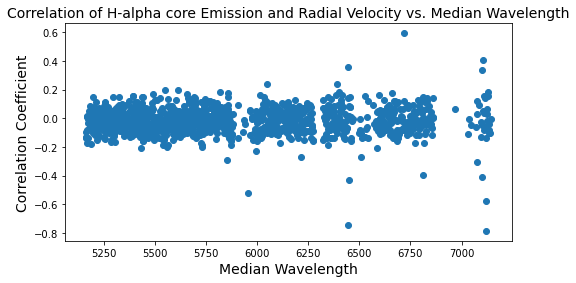

In [24]:
#Using the activity indicator H-alpha core emission
plt.scatter(time, halphacore)

plt.title('H-alpha core emission vs. Time',fontsize=16)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('H-alpha core emission',fontsize=16)
plt.show()

plt.errorbar(halphacore, velocity, yerr = velocityerr, fmt='o')
plt.title('Correlation of Radial Velocity and H-alpha core emission',fontsize=16)
plt.xlabel('H-alpha core emission',fontsize=16)
plt.ylabel('Radial Velocity',fontsize=16)
plt.show()

for icnk,ncnk in enumerate(tqdm(range(0,numchunk))):
    nan_mask = np.logical_and(np.isfinite(velo[ncnk]),np.isfinite(df['H-alpha Emission']))
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=0)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=1000)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=-1000)
    
    if np.sum(nan_mask) < 2:
        pccall[ncnk]=np.nan
        continue
    
    pcc, pcc_pval = pearsonr(velo[ncnk][nan_mask],df['H-alpha Emission'][nan_mask])
    pccall[ncnk] = pcc

plt.figure(figsize=(8,4))
plt.scatter(medwavall[:,0],pccall)

plt.title('Correlation of H-alpha core Emission and Radial Velocity vs. Median Wavelength',fontsize=14)
plt.xlabel('Median Wavelength',fontsize=14)
plt.ylabel('Correlation Coefficient',fontsize=14)
plt.show()

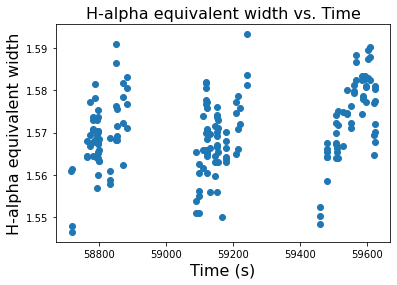

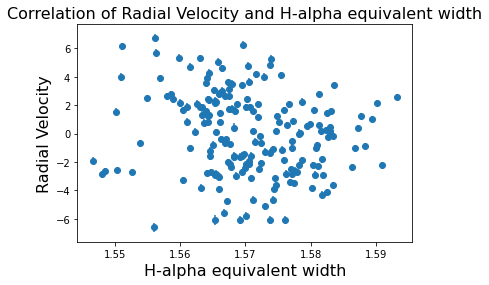

100%|██████████████████████████████████████| 1386/1386 [00:01<00:00, 741.56it/s]


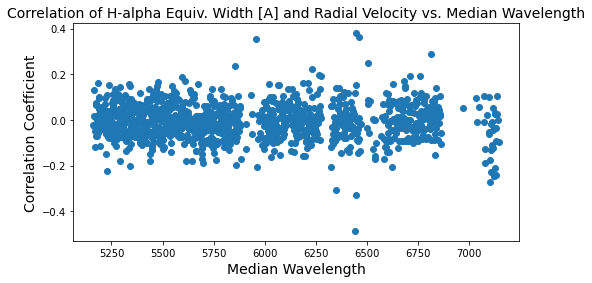

In [25]:
#Using the activity indicator H-alpha equivalent width

plt.scatter(time, halphawidth)
plt.title('H-alpha equivalent width vs. Time',fontsize=16)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('H-alpha equivalent width',fontsize=16)
plt.show()

plt.errorbar(halphawidth, velocity, yerr=velocityerr, fmt='o')
plt.title('Correlation of Radial Velocity and H-alpha equivalent width',fontsize=16)
plt.xlabel('H-alpha equivalent width',fontsize=16)
plt.ylabel('Radial Velocity',fontsize=16)
plt.show()

for icnk,ncnk in enumerate(tqdm(range(0,numchunk))):
    nan_mask = np.logical_and(np.isfinite(velo[ncnk]),np.isfinite(df['H-alpha Equiv. Width [A]']))
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=0)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=1000)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=-1000)
    
    if np.sum(nan_mask) < 2:
        pccall[ncnk]=np.nan
        continue
    
    pcc, pcc_pval = pearsonr(velo[ncnk][nan_mask],df['H-alpha Equiv. Width [A]'][nan_mask])
    pccall[ncnk] = pcc

plt.figure(figsize=(8,4))
plt.scatter(medwavall[:,0],pccall)

plt.title('Correlation of H-alpha Equiv. Width [A] and Radial Velocity vs. Median Wavelength',fontsize=14)
plt.xlabel('Median Wavelength',fontsize=14)
plt.ylabel('Correlation Coefficient',fontsize=14)
plt.show()

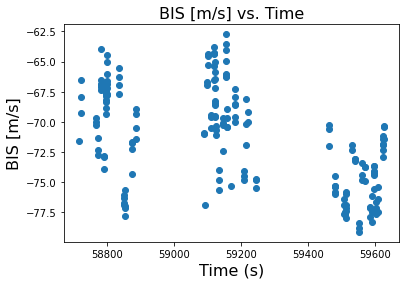

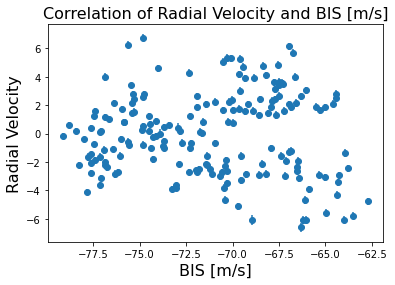

100%|██████████████████████████████████████| 1386/1386 [00:01<00:00, 768.08it/s]


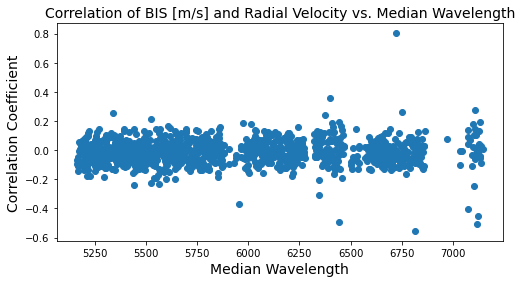

In [26]:
#Using the activity indicator bisector of the CCF

plt.scatter(time, bisccf)
plt.title('BIS [m/s] vs. Time',fontsize=16)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('BIS [m/s]',fontsize=16)
plt.show()

plt.errorbar(bisccf, velocity, yerr=velocityerr, fmt='o')
plt.title('Correlation of Radial Velocity and BIS [m/s]',fontsize=16)
plt.xlabel('BIS [m/s]',fontsize=16)
plt.ylabel('Radial Velocity',fontsize=16)
plt.show()

for icnk,ncnk in enumerate(tqdm(range(0,numchunk))):
    nan_mask = np.logical_and(np.isfinite(velo[ncnk]),np.isfinite(df['BIS [m/s]']))
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=0)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=1000)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=-1000)
    
    if np.sum(nan_mask) < 2:
        pccall[ncnk]=np.nan
        continue
    
    pcc, pcc_pval = pearsonr(velo[ncnk][nan_mask],df['BIS [m/s]'][nan_mask])
    pccall[ncnk] = pcc

plt.figure(figsize=(8,4))
plt.scatter(medwavall[:,0],pccall)

plt.title('Correlation of BIS [m/s] and Radial Velocity vs. Median Wavelength',fontsize=14)
plt.xlabel('Median Wavelength',fontsize=14)
plt.ylabel('Correlation Coefficient',fontsize=14)
plt.show()

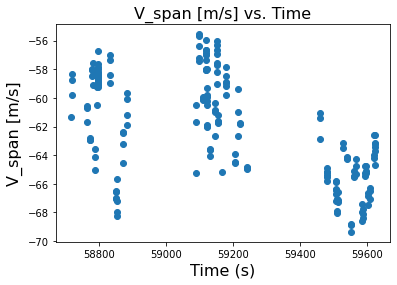

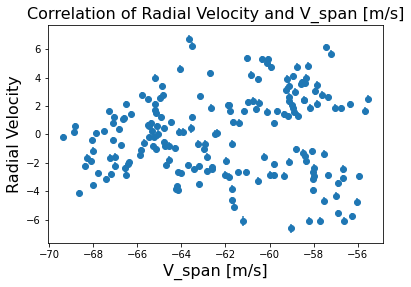

100%|██████████████████████████████████████| 1386/1386 [00:01<00:00, 929.59it/s]


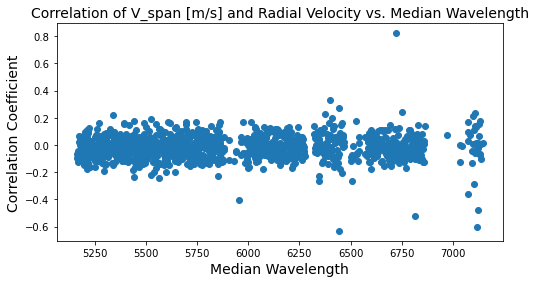

In [27]:
#Using the activity indicator V span

plt.scatter(time, velspan)
plt.title('V_span [m/s] vs. Time',fontsize=16)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('V_span [m/s]',fontsize=16)
plt.show()

plt.errorbar(velspan, velocity, yerr=velocityerr, fmt='o')
plt.title('Correlation of Radial Velocity and V_span [m/s]',fontsize=16)
plt.xlabel('V_span [m/s]',fontsize=16)
plt.ylabel('Radial Velocity',fontsize=16)
plt.show()

for icnk,ncnk in enumerate(tqdm(range(0,numchunk))):
    nan_mask = np.logical_and(np.isfinite(velo[ncnk]),np.isfinite(df['V_span [m/s]']))
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=0)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=1000)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=-1000)
    
    if np.sum(nan_mask) < 2:
        pccall[ncnk]=np.nan
        continue
    
    pcc, pcc_pval = pearsonr(velo[ncnk][nan_mask],df['V_span [m/s]'][nan_mask])
    pccall[ncnk] = pcc

plt.figure(figsize=(8,4))
plt.scatter(medwavall[:,0],pccall)

plt.title('Correlation of V_span [m/s] and Radial Velocity vs. Median Wavelength',fontsize=14)
plt.xlabel('Median Wavelength',fontsize=14)
plt.ylabel('Correlation Coefficient',fontsize=14)
plt.show()

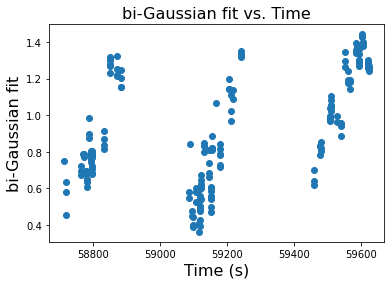

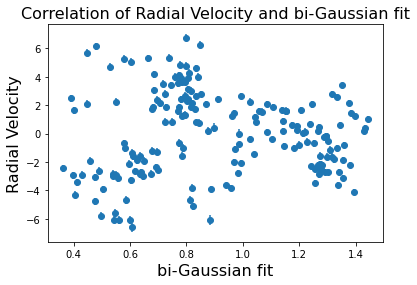

100%|██████████████████████████████████████| 1386/1386 [00:01<00:00, 810.51it/s]


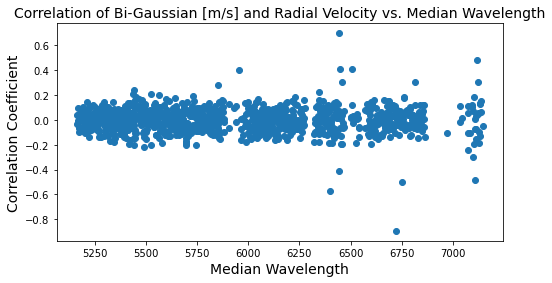

In [28]:
#Using the activity indicator bi-Gaussian fit

plt.scatter(time, bigauss)
plt.title('bi-Gaussian fit vs. Time',fontsize=16)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('bi-Gaussian fit',fontsize=16)
plt.show()

plt.errorbar(bigauss, velocity, yerr=velocityerr, fmt='o')
plt.title('Correlation of Radial Velocity and bi-Gaussian fit',fontsize=16)
plt.xlabel('bi-Gaussian fit',fontsize=16)
plt.ylabel('Radial Velocity',fontsize=16)
plt.show()

for icnk,ncnk in enumerate(tqdm(range(0,numchunk))):
    nan_mask = np.logical_and(np.isfinite(velo[ncnk]),np.isfinite(df['Bi-Gaussian [m/s]']))
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=0)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=1000)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=-1000)
    
    if np.sum(nan_mask) < 2:
        pccall[ncnk]=np.nan
        continue
    
    pcc, pcc_pval = pearsonr(velo[ncnk][nan_mask],df['Bi-Gaussian [m/s]'][nan_mask])
    pccall[ncnk] = pcc

plt.figure(figsize=(8,4))
plt.scatter(medwavall[:,0],pccall)

plt.title('Correlation of Bi-Gaussian [m/s] and Radial Velocity vs. Median Wavelength',fontsize=14)
plt.xlabel('Median Wavelength',fontsize=14)
plt.ylabel('Correlation Coefficient',fontsize=14)
plt.show()

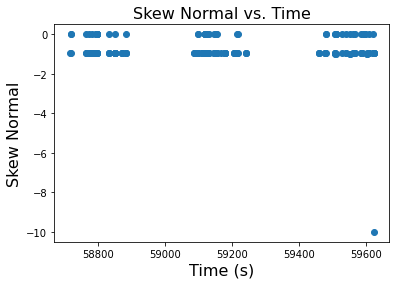

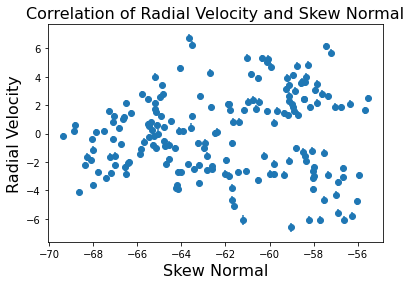

100%|██████████████████████████████████████| 1386/1386 [00:01<00:00, 843.17it/s]


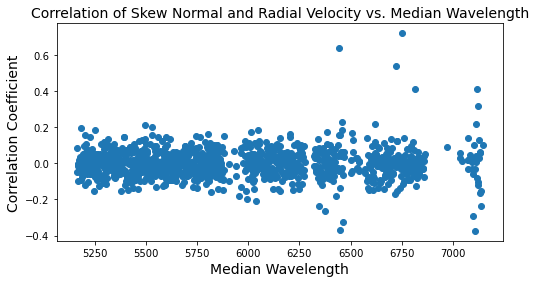

In [29]:
#Using the activity indicator skew norm

plt.scatter(time, skewnorm)
plt.title('Skew Normal vs. Time',fontsize=16)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('Skew Normal',fontsize=16)
plt.show()

plt.errorbar(velspan, velocity, yerr=velocityerr, fmt='o')
plt.title('Correlation of Radial Velocity and Skew Normal',fontsize=16)
plt.xlabel('Skew Normal',fontsize=16)
plt.ylabel('Radial Velocity',fontsize=16)
plt.show()

for icnk,ncnk in enumerate(tqdm(range(0,numchunk))):
    nan_mask = np.logical_and(np.isfinite(velo[ncnk]),np.isfinite(df['Skew Normal']))
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=0)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=1000)
    nan_mask = np.logical_and(nan_mask,velo[ncnk]!=-1000)
    
    if np.sum(nan_mask) < 2:
        pccall[ncnk]=np.nan
        continue
    
    pcc, pcc_pval = pearsonr(velo[ncnk][nan_mask],df['Skew Normal'][nan_mask])
    pccall[ncnk] = pcc

plt.figure(figsize=(8,4))
plt.scatter(medwavall[:,0],pccall)

plt.title('Correlation of Skew Normal and Radial Velocity vs. Median Wavelength',fontsize=14)
plt.xlabel('Median Wavelength',fontsize=14)
plt.ylabel('Correlation Coefficient',fontsize=14)
plt.show()